In [1]:
import datetime

import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import string
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from nltk.stem.snowball import EnglishStemmer

import pickle



In [2]:
from sklearn.decomposition import LatentDirichletAllocation

In [26]:
business = pd.read_json('yelp_dataset/business.json', lines=True)
#checkin = pd.read_json('yelp_dataset/checkin.json', lines=True)
#photo = pd.read_json('yelp_dataset/photo.json', lines=True)
#review =  pd.read_json('yelp_dataset/review.json', lines=True)
#tip = pd.read_json('yelp_dataset/tip.json', lines=True)
##user = pd.read_json('yelp_dataset/user.json', lines=True)

In [27]:
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


## Helper Function

In [7]:
def text_process(text):
    """
    Modified from
    http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/
    Takes in a string of text, then performs the following:
    1. Remove all punctuation, and digits 
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    stemmer = EnglishStemmer()
   
    # Check characters to see if they are in punctuation
    clean = [char for char in text if (char not in string.punctuation) 
            and (not char.isdigit())] 
 
    clean = ''.join(clean)
    tokens = clean.split()
    tokens = [stemmer.stem(c) for c in tokens]
    # Join the characters again to form the string.

    tokens = ' '.join(tokens)
    
    # Now just remove any stopwords
    return tokens

### Only look at restaurants

In [8]:
#lv_restaurants
restaurants = business['categories'].str.contains('Restaurants', regex=False)
restaurants = restaurants.fillna(False)
restaurants = business[restaurants]
print(restaurants.shape)
restaurants.head()

(59371, 14)


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
11,2450 E Indian School Rd,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1Dfx3zM-rW4n-31KeC8sJg,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,"{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...",1,33.495194,-112.028588,Taco Bell,85016,18,3.0,AZ
13,5981 Andrews Rd,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...",fweCYi8FmbJXHCqLnwuk8w,"Italian, Restaurants, Pizza, Chicken Wings",Mentor-on-the-Lake,"{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ...",1,41.708520,-81.359556,Marco's Pizza,44060,16,4.0,OH
17,"1775 E Tropicana Ave, Ste 29","{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian",Las Vegas,None,0,36.100016,-115.128529,Carluccio's Tivoli Gardens,89119,40,4.0,NV


In [9]:
categories_df = pd.Series(restaurants['categories']).str.get_dummies(sep=', ')

In [10]:
categories_df.head()

,& Probates,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Acupuncture,Adult Education,Adult Entertainment,Advertising,...,Wine Bars,Wine Tasting Classes,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga,Zoos
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
totals = categories_df.sum().sort_values(ascending=False)

Text(0.5,0,'Frequency')

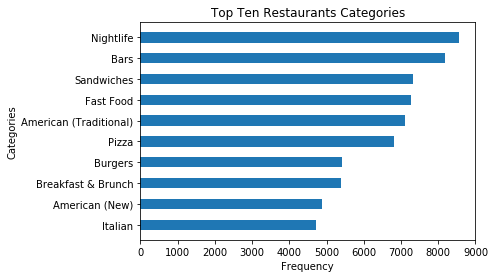

In [12]:
plt.barh(totals[11:1:-1].keys(),totals[11:1:-1], 0.5,  align='center')
plt.title('Top Ten Restaurants Categories')
plt.ylabel('Categories')
plt.xlabel('Frequency')

In [37]:
nightlife = restaurants['categories'].str.contains('Nightlife', regex=False)
nightlife = nightlife.fillna(False)
nightlife = restaurants[nightlife]

pizza = restaurants['categories'].str.contains('Pizza', regex=False)
pizza = pizza.fillna(False)
pizza = restaurants[pizza]

burgers = restaurants['categories'].str.contains('Burgers', regex=False)
burgers = burgers.fillna(False)
burgers = restaurants[burgers]
burgers.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
23,"Center Core - Food Court, Fl 3, Pittsburgh Int...","{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1RHY4K3BD22FK7Cfftn8Mg,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",Pittsburgh,None,1,40.496177,-80.246011,Marathon Diner,15231,35,4.0,PA
115,309 50 Avenue SW,"{'WiFi': ''free'', 'Caters': 'False', 'HasTV':...",qJeSjOMgWB3er3UXG33ZVw,"American (Traditional), Breakfast & Brunch, Re...",Calgary,"{'Monday': '10:30-22:0', 'Tuesday': '10:30-22:...",1,51.008460,-114.068754,Carl's Jr,T2S 1H3,6,3.5,AB
156,"1770 W Horizon Ridge, Ste 100","{'DriveThru': 'False', 'RestaurantsAttire': ''...",jScBTQtdAt-8RshaiBEHgw,"Ethnic Food, American (New), Burgers, Food, Re...",Henderson,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', '...",1,36.010745,-115.064803,Served,89012,664,4.5,NV
178,"3908 E Franklin Blvd, Ste F130","{'RestaurantsDelivery': 'False', 'DriveThru': ...",T_tnCsUQmqTMEI3XxJAyOA,"Restaurants, Beer Gardens, Nightlife, Burgers",Gastonia,None,0,35.257449,-81.111445,Howlers Craft Burgers & Beer,28056,30,3.5,NC
197,6185 W Chandler Blvd,"{'Ambience': '{'romantic': False, 'intimate': ...",FDEm-c3NAXnTVtl-hgzAhA,"Burgers, Restaurants",Chandler,"{'Monday': '11:0-20:30', 'Tuesday': '11:0-20:3...",0,33.304763,-111.948079,Heart Attack Grill,85226,104,3.0,AZ


Text(0.5,0,'Rating')

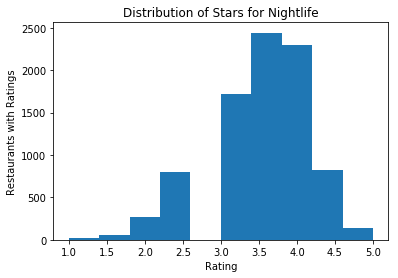

In [32]:
plt.hist(nightlife['stars'], bins = 10)
plt.title('Distribution of Stars for Nightlife')
plt.ylabel('Restaurants with Ratings')
plt.xlabel('Rating')

Text(0.5,0,'Rating')

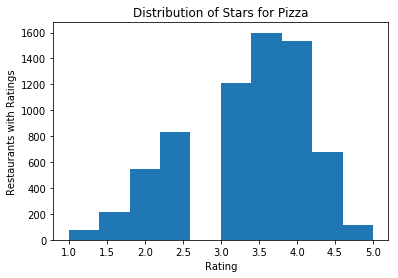

In [36]:
plt.hist(pizza['stars'], bins = 10)
plt.title('Distribution of Stars for Pizza')
plt.ylabel('Restaurants with Ratings')
plt.xlabel('Rating')

Text(0.5,0,'Rating')

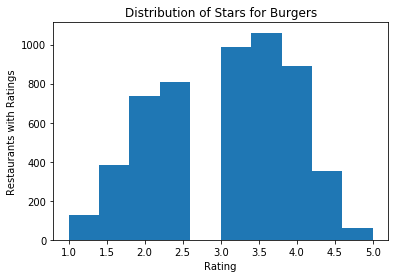

In [38]:
plt.hist(burgers['stars'], bins = 10)
plt.title('Distribution of Stars for Burgers')
plt.ylabel('Restaurants with Ratings')
plt.xlabel('Rating')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(categories_df, \
                                                    restaurants['stars'], test_size=0.33, random_state=42)


In [ ]:
#X_train = pd.Series(X_train).str.get_dummies(sep=', ')
#X_test = pd.Series(X_test).str.get_dummies(sep=', ')

In [ ]:
### Vectorized value to get categories
#vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
#categories_count = vectorizer.fit_transform(restaurants['categories']).astype(np.int8)
#categories_list = vectorizer.get_feature_names()
#categories_df = pd.DataFrame(categories_count.toarray())
#categories_df.columns = categories_list
#categories_df.head()

In [ ]:
#check for columns missing from test set
#missing_train = list(set(list(X_train)) - set(list(X_test)))
#for col in missing_train:
#    X_test[col] = 0
    
#missing_test = list(set(list(X_test)) - set(list(X_train)))
#for col in missing_test:
#    X_train[col] = 0

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
y_train_cut = pd.cut(np.array(y_train), 2, labels=[1, 2])
y_test_cut = pd.cut(np.array(y_test), 2, labels=[1, 2])
np.array(y_train_cut)

## KNN Neighbor

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, np.array(y_train_cut)) 

In [ ]:
np.array(y_test_cut)

In [ ]:
neigh.score(X_test, np.array(y_test_cut))

In [ ]:
y_pred = neigh.predict(X_test)

In [ ]:
accuracy_score(y_test_cut, y_pred)

## Linear regression

#### Ridge

In [ ]:
reg = linear_model.Ridge(alpha=.5)

In [ ]:
reg.fit(X_train, y_train)


In [ ]:
y_pred = reg.predict(X_test)
y_pred = pd.Series(y_pred)

In [ ]:
y_pred.shape

In [ ]:
y_test.shape

In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
r2_score(y_test, y_pred)  

#### Standard

In [ ]:
regL = linear_model.LinearRegression()

In [ ]:
regL.fit(X_train, y_train)


In [ ]:
y_pred = regL.predict(X_test)
y_pred = pd.Series(y_pred)

In [ ]:
y_pred.shape

In [ ]:
y_test.shape

In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
r2_score(y_test, y_pred)  

## Reviews

In [ ]:
##The Whole dataset, but running into memory issues
#start = datetime.datetime.now()

#iter_review =  pd.read_json('yelp_dataset/review.json', lines=True, chunksize=500)
#reviews_df = pd.concat([df[df['business_id'].isin(set(df['business_id']).intersection(set(restaurants['business_id'])))] for df in iter_review])

#end = datetime.datetime.now()
#elapse = end-start
#print(elapse.seconds)

In [13]:
reviews_df_file = open("reviews_df_file",'wb')
pickle.dump(reviews_df,reviews_df_file)
reviews_df_file.close()

NameError: name 'reviews_df' is not defined

In [14]:
reviews_df_file = open("reviews_df_file",'rb')
reviews_df_2 = pickle.load(reviews_df_file)
reviews_df_file.close()

EOFError: Ran out of input

In [15]:
reviews_df = pd.DataFrame()
start = datetime.datetime.now()
for df in pd.read_json('yelp_dataset/review.json', lines=True,  chunksize=1000):
    reviews_df = df[df['business_id'].isin(set(df['business_id']).intersection(set(restaurants['business_id'])))]
end = datetime.datetime.now()
elapse = end-start
print(elapse.seconds)

209


In [16]:
reviews_df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
6685000,pSMK_FtULKiU-iuh7SMKwg,0,2016-10-13 16:52:20,0,zLYNPgDU4_F50dQdx3TSoQ,5,- Made fresh right in front of you.\n- Build y...,0,XxakMGoMuleHaK8E8vjgPg
6685002,w55sCX7ZkLIJNhl_RhwjEg,0,2013-09-29 23:08:49,1,OAdpQth9cN-g0qOoKxEUMQ,3,I walked over from the Hard Rock and gave it a...,0,SSU1dl_alIw2lCphyE1WAw
6685003,HxfrVqxnsFI7MByNI7QINg,2,2013-08-01 02:38:57,0,jCoNDxz1NUElj9aI7re-Pw,4,I have been to a Joe's Crab Shack in New Jerse...,0,zX7hvqAKAD_sCbg7TaIIIw
6685006,DTz6gFeWmdvSEIFGjXpIgQ,0,2014-09-09 02:21:39,0,BfC8BsrKoWe_LP6tMtS_sQ,4,We came across Grinders by accident. I'm so g...,1,DQny4gJfywcCSMtbgY1oGg
6685007,wWvNr1sWlueHRqQrssc3iA,0,2018-02-23 14:06:17,0,RPnbi48dUdNy93vk-vhZjw,3,Let me start by saying that the service is alw...,0,kGNghQmR8SyGYAc6eOUJQw


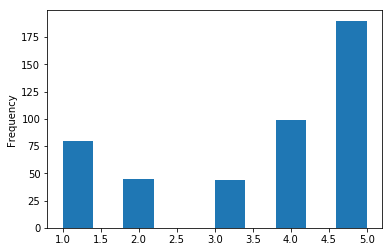

In [17]:
reviews_df.stars.plot(kind='hist')

In [ ]:
## keep the size to 1000 features for size
start = datetime.datetime.now()

reviews_df.text = reviews_df.text.apply(text_process)
vectorizer = TfidfVectorizer(analyzer='word',min_df=10, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(1, 2))
text_tfidf = vectorizer.fit_transform(reviews_df.text)
text_features = vectorizer.get_feature_names()
text_sparse_df = pd.SparseDataFrame(text_tfidf)
text_sparse_df.columns = text_features
text_sparse_df.fillna(0.0, inplace=True)

end = datetime.datetime.now()
elapse = end-start

print(elapse.seconds)

In [ ]:
reviews_df.text

In [ ]:
count_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(1, 1))
text_count = count_vectorizer.fit_transform(reviews_df.text)
text_count_features = count_vectorizer.get_feature_names()
text_count_df = pd.SparseDataFrame(text_count)
text_count_df.columns = text_count_features
text_count_df.fillna(0.0, inplace=True)

In [ ]:
text_count_df.head()

In [ ]:
text_count_totals = text_count_df.sum().sort_values(ascending=False)

In [ ]:
plt.barh(text_count_totals[11::-1].keys(),text_count_totals[11::-1], 0.5,  align='center')
plt.title('Top Ten Words in Reviews')
plt.ylabel('Words')
plt.xlabel('Frequency')

In [ ]:
countn_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(2, 4))
text_countn = countn_vectorizer.fit_transform(reviews_df.text)
text_countn_features = countn_vectorizer.get_feature_names()
text_countn_df = pd.SparseDataFrame(text_countn)
text_countn_df.columns = text_countn_features
text_countn_df.fillna(0.0, inplace=True)

In [ ]:
text_countn_totals = text_countn_df.sum().sort_values(ascending=False)

In [ ]:
plt.barh(text_countn_totals[11::-1].keys(),text_countn_totals[11::-1], 0.5,  align='center')
plt.title('Top Ten Bigram in Reviews')
plt.ylabel('Phrases')
plt.xlabel('Frequency')

In [ ]:
good_reviews = reviews_df[reviews_df.stars >= 4.0]
good_reviews.head()

In [ ]:
textg_countn = countn_vectorizer.fit_transform(good_reviews.text)
textg_countn_features = countn_vectorizer.get_feature_names()
textg_countn_df = pd.SparseDataFrame(textg_countn)
textg_countn_df.columns = textg_countn_features
textg_countn_df.fillna(0.0, inplace=True)

In [ ]:
textg_countn_totals = textg_countn_df.sum().sort_values(ascending=False)

In [ ]:
plt.barh(textg_countn_totals[7::-1].keys(),textg_countn_totals[7::-1], 0.5,  align='center')
plt.title('Top Bigrams in Good Reviews')
plt.ylabel('Phrases')
plt.xlabel('Frequency')

In [ ]:
bad_reviews = reviews_df[reviews_df.stars <= 2.0]
bad_reviews.head()

In [ ]:
textb_countn = countn_vectorizer.fit_transform(bad_reviews.text)
textb_countn_features = countn_vectorizer.get_feature_names()
textb_countn_df = pd.SparseDataFrame(textb_countn)
textb_countn_df.columns = textb_countn_features
textb_countn_df.fillna(0.0, inplace=True)

In [ ]:
textb_countn_totals = textb_countn_df.sum().sort_values(ascending=False)

In [ ]:
plt.barh(textb_countn_totals[7::-1].keys(),textb_countn_totals[7::-1], 0.5,  align='center')
plt.title('Top Bigrams in Bad Reviews')
plt.ylabel('Phrases')
plt.xlabel('Frequency')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text_sparse_df, \
                                                    reviews_df.stars, test_size=0.33, random_state=42)


In [ ]:
X_train.head()

## Models

In [ ]:
reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred = pd.Series(y_pred)

In [ ]:
print("MSE:" + str(mean_squared_error(y_test, y_pred)))
print("R2:"+ str(r2_score(y_test, y_pred)))

In [ ]:
ridgereg = linear_model.Ridge()
alpha_range = [10, 1, 0.1, 0.01, 0.001]
ridge_params = {'alpha': alpha_range}
ridge_grid = GridSearchCV(ridgereg, ridge_params, cv=10, scoring='neg_mean_squared_error', n_jobs = 4, return_train_score=True)
ridge_grid.fit(X_train, np.ravel(y_train))
ridge_results = pd.DataFrame(ridge_grid.cv_results_)
ridge_results.sort_values(by='rank_test_score').head(5)

In [ ]:
regL = linear_model.LinearRegression()
regL.fit(X_train, y_train)
y_pred_regL = regL.predict(X_test)
y_pred_regL = pd.Series(y_pred)

In [ ]:
print("MSE:" + str(mean_squared_error(y_test, y_pred_regL)))
print("R2:"+ str(r2_score(y_test, y_pred_regL)))

### LDA Topic Modeling

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print( " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
n_components_range = [10,15,20,25,30]
learning_decay_range = [0.5,0.7,0.9]
search_params = {'n_components': n_components_range, 'learning_decay': learning_decay_range}

lda = LatentDirichletAllocation(max_iter=10, learning_method='online')
lda_model = GridSearchCV(lda, param_grid=search_params, n_jobs=4)

In [ ]:
start = datetime.datetime.now()

lda_model.fit(text_count_df)

end = datetime.datetime.now()
elapse = end-start
print(elapse.seconds)

In [ ]:
no_top_words = 2
display_topics(best_lda_model, text_count_features, no_top_words)

In [ ]:
# Best Model
best_lda_model = lda_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", lda_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", lda_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(text_count_df))

In [ ]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(text_count_df)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(text_count_df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics